In [ ]:
# Install required packages

!pip install -q transformers
!pip install -q clean-text[gpl]
!pip install -q hazm

In [ ]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import collections
import hazm
import json
import copy
import os
import re

from cleantext import clean
from tqdm.notebook import tqdm


In [ ]:
#@title Kaggle Credential { display-mode: "form" }

username = '' #@param {type: "string"}
api_key = '' #@param {type: "string"}


if username and api_key:
    token = {"username": username, "key": api_key}

    !mkdir ~/.kaggle
    !mkdir /content/.kaggle
    with open('/content/.kaggle/kaggle.json', 'w') as f:
        json.dump(token, f)

    !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json

# Replace with your dataset's API command
!kaggle datasets download -d soheiltehranipour/snappfood-persian-sentiment-analysis

!unzip snappfood-persian-sentiment-analysis.zip

  0% 0.00/3.16M [00:00<?, ?B/s]
100% 3.16M/3.16M [00:00<00:00, 228MB/s]
Archive:  snappfood-persian-sentiment-analysis.zip
  inflating: Snappfood - Sentiment Analysis.csv  


In [ ]:
df = pd.read_csv('Snappfood - Sentiment Analysis.csv', delimiter='\t')
df.head(2)

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0


In [ ]:
df = df[['comment', 'label_id']]
df.head(2)

,comment,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,1.0
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,0.0


In [ ]:
# print data information
print('shape of dataframe: ', df.shape, '\n', '---------------------------------', '\n', '\n')
print('dataframe information:')
print(df.info())

shape of dataframe:  (70000, 2) 
 --------------------------------- 
 

dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   comment   70000 non-null  object 
 1   label_id  69480 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB
None


In [ ]:
# print missing values information
print(df.isnull().sum(),'\n', '---------------------------------', '\n' )

# print some missing values
print('some missing values')
print(df[df['label_id'].isnull()].iloc[:5])

comment       0
label_id    520
dtype: int64 
 --------------------------------- 

some missing values
    comment  label_id
21      SAD       NaN
89      SAD       NaN
161     SAD       NaN
180     SAD       NaN
243   HAPPY       NaN


In [ ]:
#drop rows include NAN value
df.dropna(axis=0, inplace=True)

#reset dataframe index
df = df.reset_index(drop=True)

print('shape of dataframe:')
print(df.shape, '\n')

print('missing values stats:')
print(df.isnull().sum())

shape of dataframe:
(69480, 2) 

missing values stats:
comment     0
label_id    0
dtype: int64


In [ ]:
fig = go.Figure()

groupby_rate = df.groupby('label_id')['label_id'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.4,
    bargroupgap=0.2)

fig.show()

In [ ]:
df['words_count'] = df['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = df['words_count'].min() , df['words_count'].max()
print(f'Text Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Text Min: 2 	Max: 378


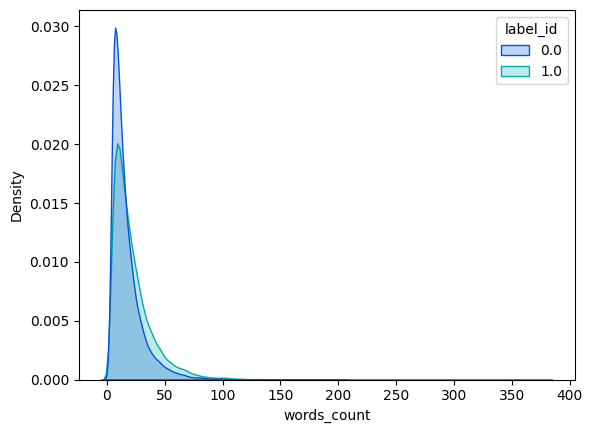

In [ ]:
sns.kdeplot(x = df['words_count'], hue=df['label_id'], palette='winter', fill=True, warn_singular=False)
plt.show()

In [ ]:
from hazm import WordTokenizer, Normalizer
import string

normalizer = Normalizer()
punctuations = string.punctuation + "," + "،"

def normalize_text(text):

  text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )


  translator = str.maketrans('', '', punctuations)
  normalized_text = normalizer.normalize(text)


  wierd_pattern = re.compile("["
        u"\u200c"
        "]+", flags=re.UNICODE)

  text = wierd_pattern.sub(r'', normalized_text)

  return text

In [ ]:
df['cleaned_comment'] = df['comment'].apply(normalize_text)
df.sample(3)

,comment,label_id,words_count,cleaned_comment
62204,من اصلا اهل نظر دادن منفی نیستم. دوبار سفارش د...,1.0,92,من اصلا اهل نظر دادن منفی نیستم. دوبار سفارش د...
55774,سیگار مارلبرو انقدر قدیمی بود که حتی بسته بندی...,0.0,12,سیگار مارلبرو انقدر قدیمی بود که حتی بسته بندی...
46029,پیک پنج دقیقه پیش از رسیدن و تحویل، گزینه تحوی...,1.0,24,پیک پنج دقیقه پیش از رسیدن و تحویل، گزینه تحوی...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['label_id'], test_size=0.1, random_state=42, stratify=df['label_id'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

X_train = X_train.tolist()
#y_train = y_train.tolist()
X_test = X_test.tolist()
#y_test = y_test.tolist()
X_val = X_val.tolist()
#y_val = y_val.tolist()


(56278,)
(6948,)
(6254,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# y_train = to_categorical(y_train, num_classes=128)
# y_val = to_categorical(y_val, num_classes=128)
# y_test = to_categorical(y_test, num_classes=128)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(56278, 2)
(6254, 2)
(6948, 2)


In [ ]:
# general config
MAX_LEN = 120
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

EPOCHS = 1
#EEVERY_EPOCH = 1000
LEARNING_RATE = 1e-5
#CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-base-parsbert-uncased'

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH)

In [ ]:
X_train = tokenizer(
    text=X_train,
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,  #because we dont have pair sentence
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=X_test,
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val = tokenizer(
    text=X_val,
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(TRAIN_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(TEST_BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(VALID_BATCH_SIZE)

In [ ]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

    return model

In [ ]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# train_dataset = train_dataset.map(lambda x, y: (x['input_ids'], x['attention_mask'], y))
# val_dataset = val_dataset.map(lambda x, y: (x['input_ids'], x['attention_mask'], y))


##%%time

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1)

# final_accuracy = history.history['val_accuracy']
# print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

1759/1759 [==============================] - 1882s 1s/step - loss: 0.3295 - accuracy: 0.8535 - val_loss: 0.3128 - val_accuracy: 0.8661


In [ ]:
result = model.evaluate(test_dataset, batch_size=TEST_BATCH_SIZE)
print(dict(zip(model.metrics_names, result)))


218/218 [==============================] - 56s 259ms/step - loss: 0.3119 - accuracy: 0.8698
{'loss': 0.3118637204170227, 'accuracy': 0.8698186278343201}
